In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 0
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,22
1,40557.96,1,20,12622.05362,20
2,89627.50,0,12,11440.79806,15
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,7


In [6]:
def imprime_resultados(results):
    media = results['test_score'].mean() * 100
    desvio = results['test_score'].std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [7]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score = False)
imprime_resultados(results)

Accuracy médio 76.64
Intervalo [74.98, 78.30]


In [8]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score = False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.56, 78.00]


In [9]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [10]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.68
Intervalo [76.63, 80.73]


In [11]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [12]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score = False)
imprime_resultados(results)

Accuracy médio 77.20
Intervalo [75.22, 79.19]


# Explorando hiper parâmetros em uma dimensão

In [13]:
def roda_arvore_de_decisao(max_depth):
    SEED = 0
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
    tabela = [max_depth, train_score, test_score]
    return tabela
  
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns= ["max_depth","train","test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.76, teste = 78.68
Arvore max_depth = 4, treino = 78.79, teste = 78.66
Arvore max_depth = 5, treino = 78.96, teste = 78.56
Arvore max_depth = 6, treino = 79.15, teste = 78.55
Arvore max_depth = 7, treino = 79.40, teste = 78.34
Arvore max_depth = 8, treino = 79.85, teste = 77.94
Arvore max_depth = 9, treino = 80.38, teste = 77.63
Arvore max_depth = 10, treino = 81.11, teste = 77.22
Arvore max_depth = 11, treino = 81.96, teste = 76.70
Arvore max_depth = 12, treino = 82.90, teste = 76.51
Arvore max_depth = 13, treino = 84.01, teste = 76.16
Arvore max_depth = 14, treino = 85.05, teste = 75.94
Arvore max_depth = 15, treino = 86.15, teste = 75.22
Arvore max_depth = 16, treino = 87.23, teste = 75.05
Arvore max_depth = 17, treino = 88.26, teste = 74.66
Arvore max_depth = 18, treino = 89.24, teste = 74.56
Arvore max_depth = 19, treino = 90.25, teste = 74.31
Ar

,max_depth,train,test
0,1,75.791115,75.780148
1,2,75.791115,75.780148
2,3,78.755567,78.681502
3,4,78.792212,78.661432
4,5,78.958858,78.560017


<AxesSubplot:xlabel='max_depth', ylabel='train'>

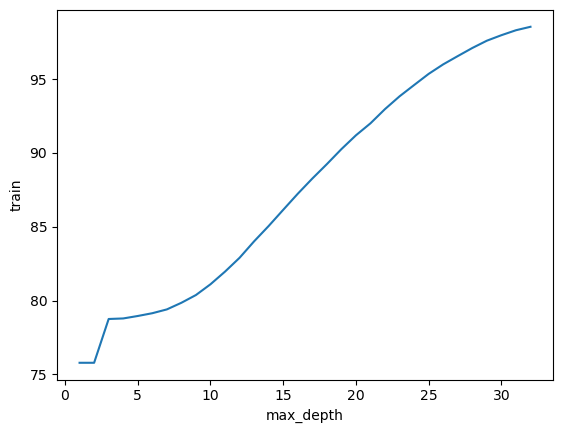

In [14]:
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados)

# OVERFIT: ficou "perfeito" para o treino mas ruim para o teste

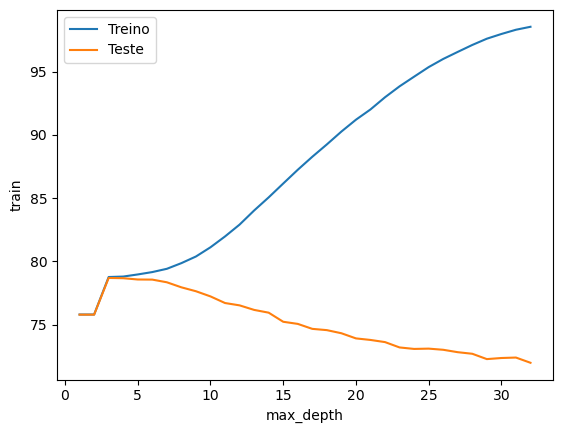

In [15]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

In [16]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.755567,78.681502
3,4,78.792212,78.661432
4,5,78.958858,78.560017
5,6,79.146765,78.550577
6,7,79.404584,78.339605


# Explorando hiper parâmetros em 2 dimensões

In [17]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 0
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.69
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.69
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.69
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.69
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.69
Arvore max_depth = 

Arvore max_depth = 28, min_samples_leaf = 32, treino = 80.87, teste = 76.60
Arvore max_depth = 28, min_samples_leaf = 64, treino = 79.78, teste = 77.47
Arvore max_depth = 28, min_samples_leaf = 128, treino = 79.25, teste = 78.06
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.91, teste = 78.03
Arvore max_depth = 29, min_samples_leaf = 32, treino = 80.87, teste = 76.60
Arvore max_depth = 29, min_samples_leaf = 64, treino = 79.78, teste = 77.47
Arvore max_depth = 29, min_samples_leaf = 128, treino = 79.25, teste = 78.06
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.91, teste = 78.03
Arvore max_depth = 30, min_samples_leaf = 32, treino = 80.87, teste = 76.60
Arvore max_depth = 30, min_samples_leaf = 64, treino = 79.78, teste = 77.47
Arvore max_depth = 30, min_samples_leaf = 128, treino = 79.25, teste = 78.06
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.91, teste = 78.03
Arvore max_depth = 31, min_samples_leaf = 32, treino = 80.87, teste = 76.60
Arvore

,max_depth,min_samples_leaf,train,test
0,1,32,75.791115,75.780148
1,1,64,75.791115,75.780148
2,1,128,75.791115,75.780148
3,1,256,75.791115,75.780148
4,2,32,75.791115,75.780148


In [18]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.752241,78.691727
8,3,32,78.752241,78.691727
9,3,64,78.752241,78.691727
10,3,128,78.752241,78.691727
11,3,256,78.752241,78.691727


In [19]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.545543,-0.049232
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.399976,0.430135
train,5.455431e-01,-3.999762e-01,1.000000,0.055366
test,-4.923236e-02,4.301355e-01,0.055366,1.000000


<AxesSubplot:>

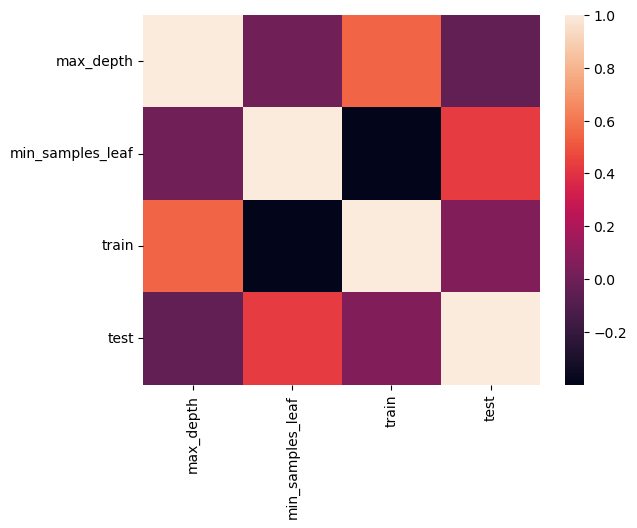

In [20]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

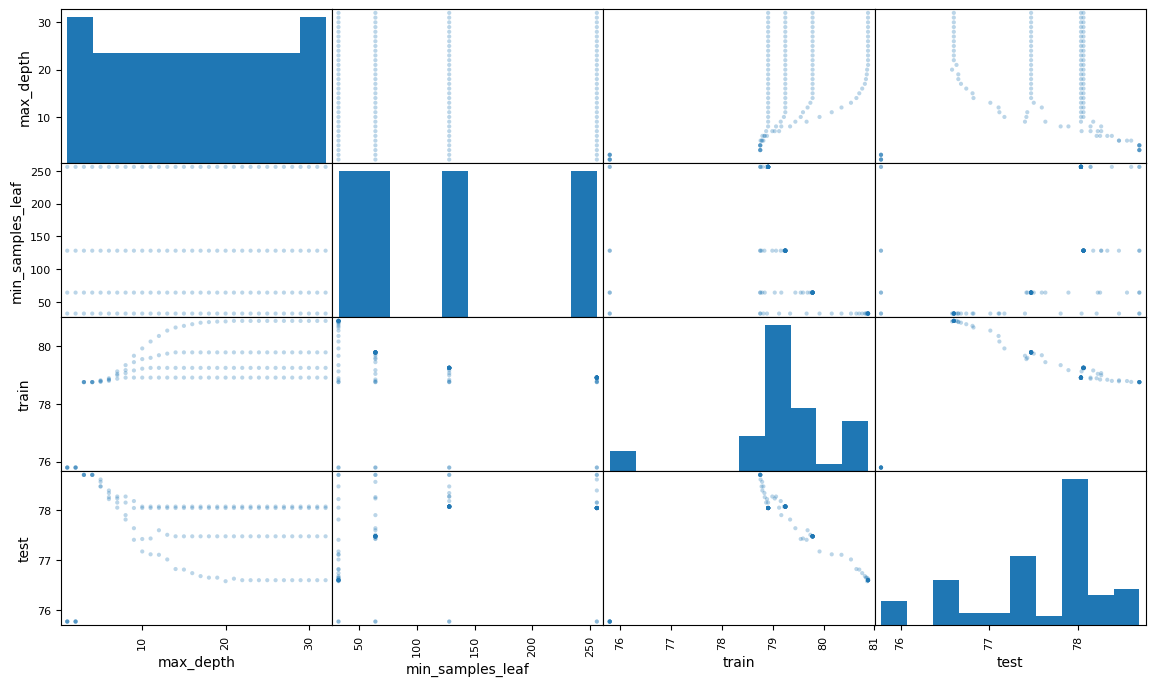

In [21]:
pd.plotting.scatter_matrix(resultados, figsize = (14, 8), alpha = 0.3)

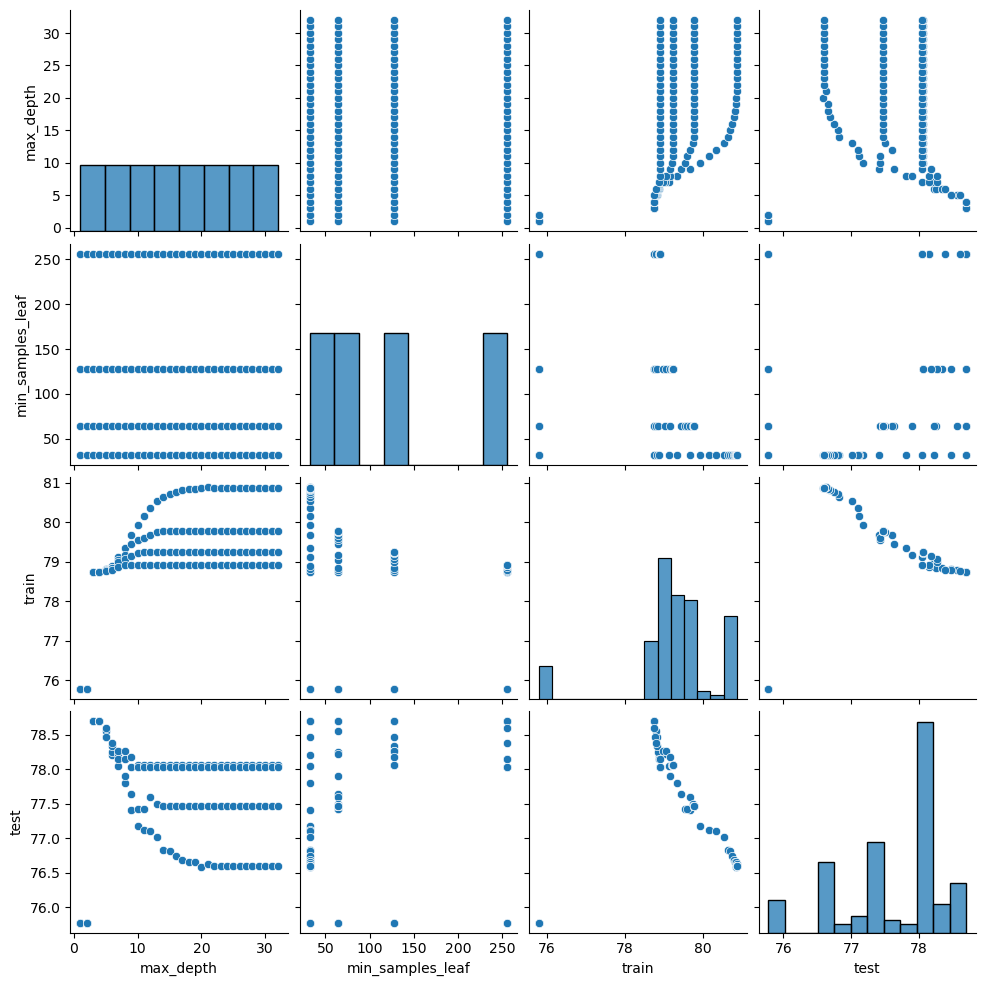

In [22]:
sns.pairplot(resultados)

C:\Users\Micaeld\AppData\Local\Temp\ipykernel_5996\1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

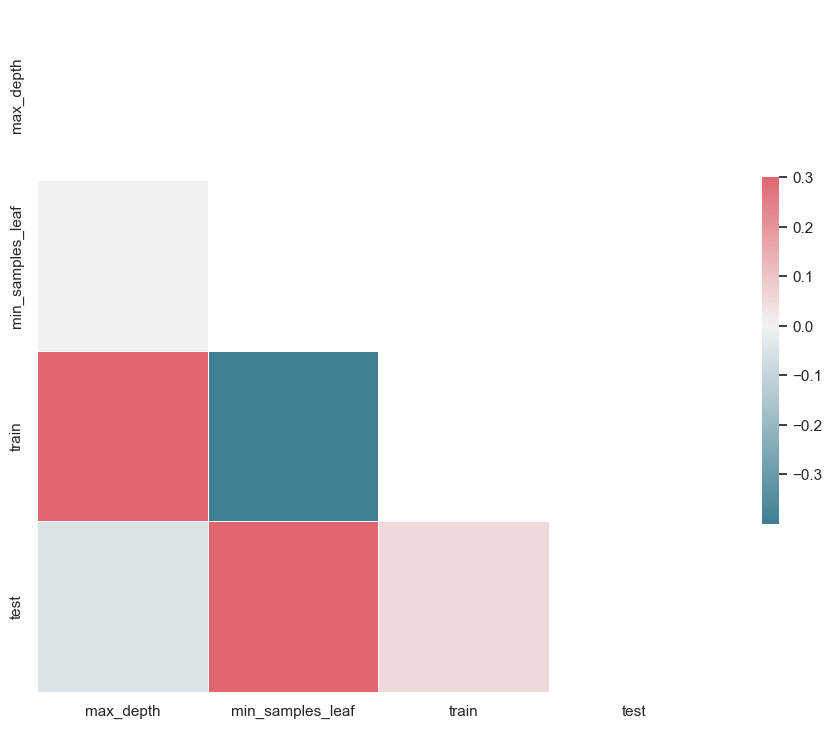

In [23]:
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

In [24]:
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.69
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.69
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.69
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.52, teste = 77.52
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.69
Arvore max_d

Arvore max_depth = 28, min_samples_leaf = 128, treino = 79.25, teste = 78.06
Arvore max_depth = 28, min_samples_leaf = 192, treino = 79.02, teste = 77.87
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.91, teste = 78.03
Arvore max_depth = 28, min_samples_leaf = 512, treino = 77.52, teste = 77.52
Arvore max_depth = 29, min_samples_leaf = 128, treino = 79.25, teste = 78.06
Arvore max_depth = 29, min_samples_leaf = 192, treino = 79.02, teste = 77.87
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.91, teste = 78.03
Arvore max_depth = 29, min_samples_leaf = 512, treino = 77.52, teste = 77.52
Arvore max_depth = 30, min_samples_leaf = 128, treino = 79.25, teste = 78.06
Arvore max_depth = 30, min_samples_leaf = 192, treino = 79.02, teste = 77.87
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.91, teste = 78.03
Arvore max_depth = 30, min_samples_leaf = 512, treino = 77.52, teste = 77.52
Arvore max_depth = 31, min_samples_leaf = 128, treino = 79.25, teste = 78.06

,max_depth,min_samples_leaf,train,test
0,1,128,75.791115,75.780148
1,1,192,75.791115,75.780148
2,1,256,75.791115,75.780148
3,1,512,75.791115,75.780148
4,2,128,75.791115,75.780148


In [25]:
corr = resultados.corr()

C:\Users\Micaeld\AppData\Local\Temp\ipykernel_5996\1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

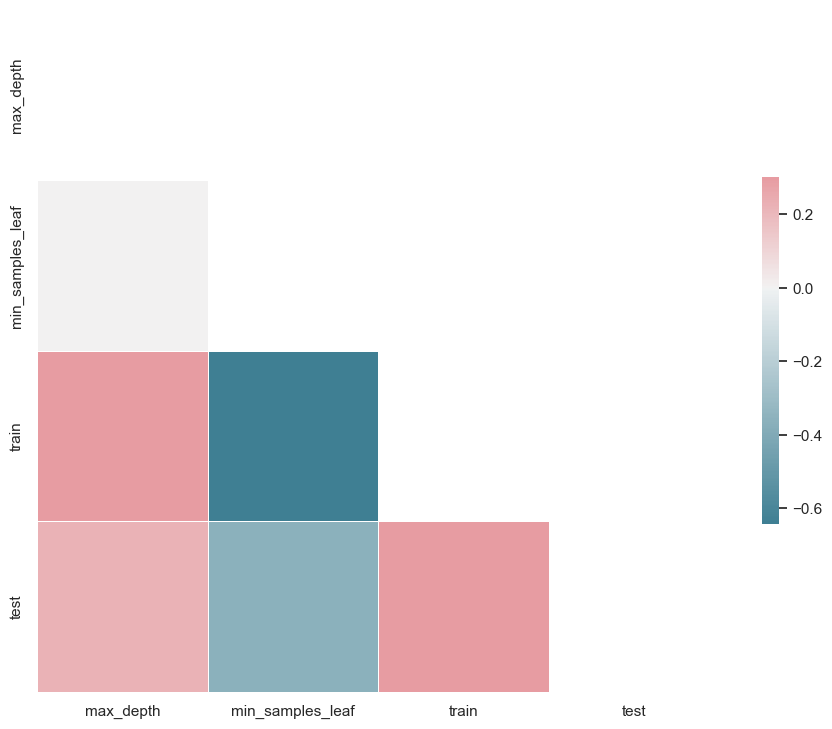

In [26]:
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
9,3,192,78.752241,78.691727
14,4,256,78.752241,78.691727
13,4,192,78.752241,78.691727
12,4,128,78.752241,78.691727
10,3,256,78.752241,78.691727


# Explorando 3 dimensões de hiper parâmetros

In [28]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 0
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
    return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791115,75.780148,0.005396,0.001699
1,1,32,64,75.791115,75.780148,0.004799,0.001501
2,1,32,128,75.791115,75.780148,0.005896,0.001998
3,1,32,256,75.791115,75.780148,0.004798,0.001601
4,1,64,32,75.791115,75.780148,0.005596,0.001668


In [29]:
corr = resultados.corr()

C:\Users\Micaeld\AppData\Local\Temp\ipykernel_5996\1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

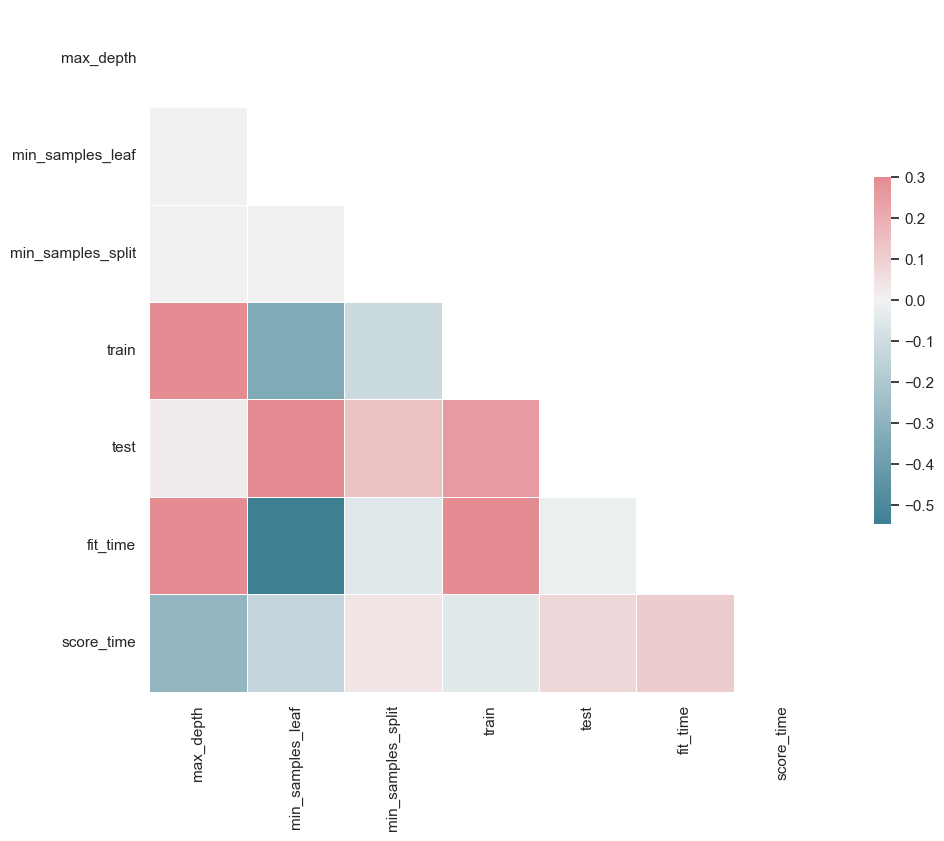

In [30]:
sns.set(style="white")

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

In [31]:
resultados.sort_values("test", ascending = False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
33,3,32,64,78.752241,78.691727,0.009195,0.001801
43,3,128,256,78.752241,78.691727,0.009093,0.001700
47,3,256,256,78.752241,78.691727,0.009592,0.002099
42,3,128,128,78.752241,78.691727,0.009594,0.002398
46,3,256,128,78.752241,78.691727,0.011195,0.001898


# Explorando espaço de hiper parâmetros com GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008592,0.000484,0.001799,0.000398,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.782266,...,0.773006,0.786359,0.78125,0.782779,0.788153,0.782347,0.802187,0.786917,0.010101,1
1,0.009197,0.000396,0.002096,0.000304,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.782266,...,0.773006,0.786359,0.78125,0.782779,0.788153,0.782347,0.802187,0.786917,0.010101,1
2,0.008794,0.000597,0.002101,0.000302,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.782266,...,0.773006,0.786359,0.78125,0.782779,0.788153,0.782347,0.802187,0.786917,0.010101,1
3,0.008298,0.000458,0.001198,0.000403,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.782266,...,0.773006,0.786359,0.78125,0.782779,0.788153,0.782347,0.802187,0.786917,0.010101,1
4,0.007998,0.000447,0.001397,0.000489,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.782266,...,0.773006,0.786359,0.78125,0.782779,0.788153,0.782347,0.802187,0.786917,0.010101,1


In [33]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.69172738774513


In [34]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [35]:
from sklearn.metrics import accuracy_score

# evitar essa abordagem pois estará sendo otimista

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


In [36]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

C:\Users\Micaeld\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Micaeld\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Micaeld\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\Micaeld\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(sel

### Infelizmente como o Pandas não suporta nested validation com group k fold não consegui prever o resultado para novos grupos

In [37]:
from sklearn.model_selection import GridSearchCV, KFold

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle = True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008194,0.000400,0.001999,7.294206e-07,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.007395,0.000490,0.002000,1.370440e-06,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.008195,0.000400,0.001402,4.893124e-04,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.007388,0.000487,0.001604,4.910094e-04,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.007398,0.000483,0.001596,4.866964e-04,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [39]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [40]:
imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [41]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


_